In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
# loading The Dataset
with open('/home/saeedmohseni/Desktop/LLM/Dataset/text.txt', 'r', encoding='utf-8') as f:
#with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  160046


In [4]:
# hyperparameters:
learning_rate = 3e-4
batch_size = 64
n_layer = 5
n_head = 5
context_size = 256;
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200;
n_embed =256
dropout = 0.2



In [5]:
# Properties of the given text, unique elements and the vocabulary size.
chars = sorted(list(set(text)))
vocabulary_size = len(chars)
print(f"unique characters are: {''.join(chars)}")
print(f"\n number of unique characters in the text: {vocabulary_size}")

unique characters are: 
 !"',-.38:;?ABCDEFGHIJKLMNOPQRSTUVWYZabcdefghijklmnopqrstuvwxyzâœ“”€™

 number of unique characters in the text: 70


In [6]:
# Tokenizing the characters:
encoder = lambda text: [chars.index(c) for c in text]
decoder = lambda tokenized_text: ''.join([chars[token] for token in tokenized_text])

print(encoder("This is Saeed"))
print(decoder(encoder("This is Saeed")))

[32, 45, 46, 56, 1, 46, 56, 1, 31, 38, 42, 42, 41]
This is Saeed


In [7]:
data = torch.tensor(encoder(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[0:99])

torch.Size([160046]) torch.int64
tensor([27, 51, 42,  1, 41, 38, 62,  5,  1, 38,  1, 49, 46, 57, 57, 49, 42,  1,
        44, 46, 55, 49,  1, 51, 38, 50, 42, 41,  1, 24, 46, 49, 62,  1, 43, 52,
        58, 51, 41,  1, 38,  1, 51, 42, 42, 41, 49, 42,  1, 46, 51,  1, 45, 42,
        55,  1, 55, 52, 52, 50,  7,  1, 31, 45, 42,  1, 48, 51, 42, 60,  1, 46,
        57,  1, 60, 38, 56,  1, 41, 46, 43, 43, 46, 40, 58, 49, 57,  1, 57, 52,
         1, 53, 49, 38, 62,  1, 60, 46, 57])


In [8]:
train_data = data[:int(0.9*len(data))]
val_data = data[int(0.9*len(data)):]
print(train_data.shape, val_data.shape)
print(val_data.shape, data.dtype)

torch.Size([144041]) torch.Size([16005])
torch.Size([16005]) torch.int64


In [9]:
@torch.no_grad()
def get_loss():
  loss ={'train': 0, 'val':0}
  model.eval()
  for split in ['train', 'val']:
    for i in range(eval_iters):
      x, y = get_batch(split, batch_size)
      logits, temp = model(x, y)
      loss[split] = loss[split] + temp.item()
    loss[split]  = loss[split] / eval_iters
  model.train()
  return loss

In [10]:

def get_batch(indicator, batch_size):
  data = train_data if indicator == 'train' else val_data
  ix = torch.randint(len(data) - context_size, (batch_size,))
  x = torch.stack([data[j:j+context_size] for j in ix])
  y = torch.stack([data[j+1:j+context_size+1] for j in ix])
  x, y = x.to(device), y.to(device)
  return x, y


In [11]:
# Head module (self attention):
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embed, head_size, bias=False)
    self.query = nn.Linear(n_embed, head_size, bias=False)
    self.value = nn.Linear(n_embed, head_size, bias=False)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('tril', torch.tril(torch.ones(context_size, context_size)))

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)
    q = self.query(x)
    v = self.value(x)
    wei = q @ k.transpose(-2, -1) * C**-0.5
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    out = wei @ v
    return out

class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(head_size * num_heads, n_embed)
    self.dropout = nn.Dropout(dropout)
  def forward(self, x):
    return self.dropout(self.proj(torch.cat([h(x) for h in self.heads], dim=-1)))


class FeedForward(nn.Module):
  def __init__(self, n_embed):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embed, 4 * n_embed),
        nn.ReLU(),
        nn.Linear(4 * n_embed, n_embed),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  def __init__(self, n_embed, n_head):
    super().__init__()
    head_size = n_embed // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

In [12]:


class BigramLM(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocabulary_size, n_embed)
    self.position_embedding_table = nn.Embedding(context_size, n_embed)
    self.lm_head = nn.Linear(n_embed, vocabulary_size)
    self.blocks = nn.Sequential( *[Block(n_embed, n_head) for _ in range(n_layer)] )
    self.ln_f = nn.LayerNorm(n_embed)
    #self.blocks = nn.Sequential(
    #    Block(n_embed, n_head),
    #    Block(n_embed, n_head),
    #    Block(n_embed, n_head),

    self.sa_head = MultiHeadAttention(4, n_embed//4)
    self.ffwd = FeedForward(n_embed)

  def forward(self, idx, targets=None):
    B, T = idx.shape
    token_embed = self.token_embedding_table(idx)
    pos_embed = self.position_embedding_table(torch.arange(T, device=device))
    token_embed = token_embed + pos_embed
    x = self.blocks(token_embed)
    x = self.ln_f(x)
    logits = self.lm_head(x) # (B,T,C)
    B, T, C = logits.shape

    #logits = logits @ torch.triu(torch.mean(torch.ones(B,T), dim=1))

    if targets is None:
      loss = None
    else:
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      truncate_idx = idx[:, -context_size:]
      logits, loss = self(truncate_idx)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      next_char = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, next_char), dim=1)
    return idx

x, y = get_batch('train', batch_size)
model = BigramLM().to(device)
logits, loss = model(x, y)
print(logits.shape)
print(loss)
print((model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)))
print(decoder(model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)[0].tolist()))
#

torch.Size([16384, 70])
tensor(4.4106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([[ 0, 49, 65, 25, 56, 69, 12, 59, 26, 60, 61, 28, 57, 29, 26, 18, 53, 61,
         59, 56,  8, 44,  7, 26, 24, 65, 45, 29, 55, 17, 17, 65, 53, 53, 66, 17,
         24,  6, 24, 67, 52, 61, 21, 17, 65, 48,  1, 42, 28, 31,  0, 69, 22, 57,
          7, 57, 17,  2, 17,  7, 26, 35, 34, 19, 31, 27, 66, 29, 11, 34, 16, 21,
         37, 12, 40, 48,  5, 47, 52, 12, 31, 48,  9, 32, 54, 11, 63, 11, 24, 48,
         13,  1, 24, 37, 27, 50, 14, 53, 65, 11, 17]], device='cuda:0')

ea?âuSoJFvb:Quiqbqat,Mdbpœl.D
yœwyx'AOK™;ZNdUCBK?;x,U"pœwpBDVmQo,€âQSTCxuDjCqœqMI.Ydax“-3!b.nA,œtR:y


In [13]:
# optimization:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)


epoch = 1000

train_loss = np.zeros([epoch,1])
val_loss = np.zeros([epoch,1])

for steps in range(epoch):
  x, y = get_batch('train', batch_size)
  logits, loss = model(x, y)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  
  loss = get_loss()
  train_loss[steps,0] = loss['train']
  val_loss[steps,0] = loss['val']
  if (steps+1) % eval_iters == 0:
    loss = get_loss()
    print(f"step: {steps+1}, train loss: {loss['train']:.4f}, val loss: {loss['val']:.4f}")

step: 200, train loss: 2.1812, val loss: 2.2402
step: 400, train loss: 1.5084, val loss: 1.6669
step: 600, train loss: 1.1669, val loss: 1.4296
step: 800, train loss: 0.9655, val loss: 1.3451
step: 1000, train loss: 0.8032, val loss: 1.3444


In [14]:
print((model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)))
print(decoder(model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=200)[0].tolist()))

tensor([[ 0, 27, 51, 40, 42,  1, 58, 53, 52, 51,  1, 38,  1, 43, 55, 46, 42, 51,
         41,  5,  1, 17, 49, 49, 38,  1, 43, 52, 49, 49,  1, 60, 38, 56,  1, 22,
         52, 62,  7,  1, 32, 45, 42, 55, 42,  1, 60, 38, 56,  1, 38, 49, 49,  1,
         56, 60, 42, 42, 57,  1, 40, 49, 46, 50, 56, 42, 49, 46, 51, 44,  1, 46,
         51,  1, 57, 45, 42,  1, 39, 38, 61,  7,  0,  0, 32, 45, 42, 62,  1, 49,
         52, 52, 48, 42, 41,  1, 38, 57,  1, 57, 45]], device='cuda:0')

yearlived around and had a differ named Tim. Unte to the animals goodbye. And the looking. Nowhered a lot of together to wair? He was so happy and wanted for his continue, but it. He took to ssat tigh


In [15]:
torch.save(model.state_dict(), '../SavedModels/model.pth')

In [16]:

model.load_state_dict(torch.load('../SavedModels/model.pth', map_location=torch.device('cpu')))

/localscratch-nvme/3514100/ipykernel_3379332/1551055486.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../SavedModels/model.pth', map_

<All keys matched successfully>

In [17]:
print((model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)))
print(decoder(model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=500)[0].tolist()))

tensor([[ 0, 52, 38,  1, 62, 52, 58, 55,  1, 38, 50, 59, 42, 55, 62,  1, 41, 38,
         62,  5,  3,  1, 56, 45, 42,  1, 56, 38, 46, 41,  5,  1,  3, 24, 46, 63,
         46, 53, 53, 46, 51, 44,  1, 46, 51,  1, 60, 42,  1, 57, 45, 42,  1, 53,
         38, 55, 48,  1, 41, 52, 60, 51,  7,  1, 24, 46, 57, 57, 49, 42,  1, 22,
         38, 51, 42,  1, 49, 46, 57, 57, 49, 42,  1, 44, 46, 55, 49,  1, 51, 38,
         50, 42, 41,  1, 13, 50, 62,  7,  1, 21,  4]], device='cuda:0')

When fold out the fowerst. He had a little girl and was slike give a wonderful to his fraio. Frank Jim found named Fluffy together. One no play where yvere saw a wanter to play and int of the flower. 

Sue watched as the lady, he thinked goody the luck and felt all oneved what happy. Then, his forgood and and played day.

Once upon a time, therer called to laught for a magical her toy, and said. He lived in and the little girl gasspok hurtly sure the sprange of naughty. As Rita tree throughted a


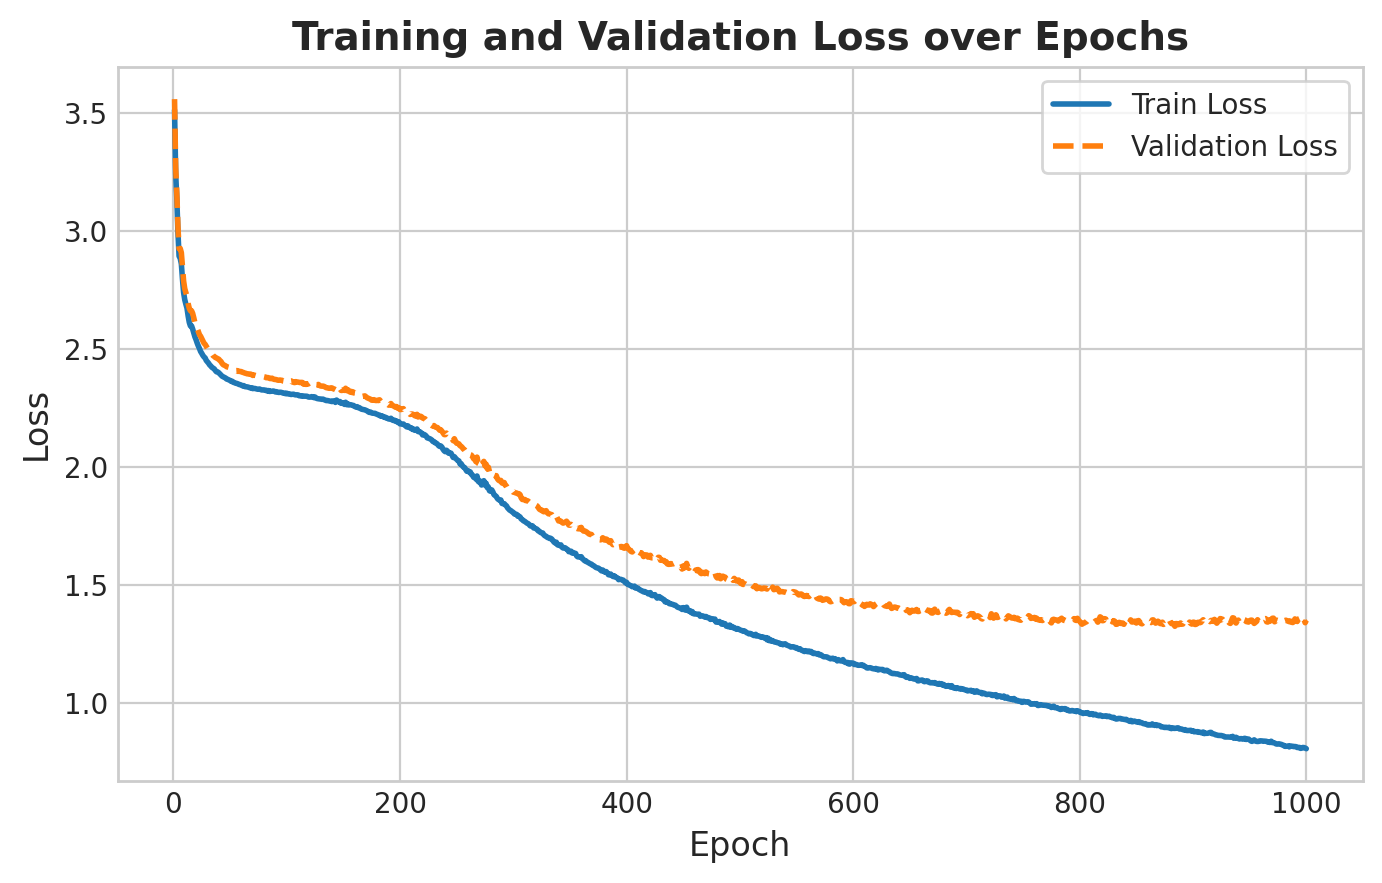

In [ ]:
%config InlineBackend.figure_format = 'retina'

train_loss = train_loss.flatten()
val_loss = val_loss.flatten()
epochs = np.arange(1, len(train_loss) + 1)

# --- Plot ---
plt.style.use("seaborn-v0_8-whitegrid")  # clean style

plt.figure(figsize=(7, 4.5))
plt.plot(epochs, train_loss, label="Train Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2, linestyle="--")

plt.title("Training and Validation Loss over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()

In [40]:
#print((model.generate(torch.unsqueeze(torch.tensor(encoder("This is Saeed"), dtype=torch.long, device=device),0), max_new_tokens=100)))
print(decoder(model.generate(torch.unsqueeze(torch.tensor(encoder("The Girl "), dtype=torch.long, device=device),0), max_new_tokens=100)[0].tolist()))

The Girl cake the scape was depare and was happy. She was so happy time, bigger thange.
One was a small, shri


In [38]:
A = torch.unsqueeze(torch.tensor(encoder("This is Saeed"), dtype=torch.long, device=device),0)

In [25]:
A.shape


torch.Size([1, 13])